# Generates a flow (demand) file
#### Either fully random or it is possible to determine some main roads and side roads and generate different demand levels on them

In [1]:
from read_roadmap import read_roadmap
from write_json import write_json_flow_file
from plot_histogram import plot_distribution

from collections import Counter
import numpy as np

In [2]:
A1 = {i: [f"road_0_{i}_0", f"road_30_{i}_0"] for i in range(9,12)}
A2 = {i: [f"road_31_{i}_2", f"road_1_{i}_2"] for i in range(9,12)}
A3 = {i: [f"road_0_{i}_0", f"road_30_{i}_0"] for i in range(1,7)}
A4 = {i: [f"road_31_{i}_2", f"road_1_{i}_2"] for i in range(1,7)}

D = {i: [f"road_0_{i}_0", f"road_1_{i}_2"] for i in range(7,9)}

B1 = {i: [f"road_{i}_12_3", f"road_{i}_1_3"] for i in range(1, 11)}
B2 = {i: [f"road_{i}_0_1", f"road_{i}_11_1"] for i in range(1, 11)}
C1 = {i: [f"road_{i}_12_3", f"road_{i}_1_3"] for i in range(11, 31)}
C2 = {i: [f"road_{i}_0_1", f"road_{i}_11_1"] for i in range(11, 31)}

all_main_roads = {"A1": A1, "A2": A2, "A3": A3, "A4": A4, "D": D, "B1": B1, "B2": B2, "C1": C1, "C2": C2}

# mapping: if we want all exits from A1 -> A2, we need to look at the values of dictionary A1 --> mapping["A2"]
mapping = {"A1": "A2", "A2": "A1", "A3": "A4", "A4": "A3", "D": "D", "B1": "B2", "B2": "B1", "C1": "C2", "C2": "C1"}

In [8]:
def main(subdirect, random_routes, random_vehicle_parameters):
    
    Road_map_Json = f"../../Simulation_Results/{subdirect}/roadnet.json"
    Dir_FlowFile_Json = f"../../Simulation_Results/{subdirect}/"
    FlowFile_Json = "flow.json"
    
    # if we want inflow / outflow from specific lanes, we can just overwrite roads_IN and roads_OUT
    roads_IN, roads_OUT, road_adj_to_IN, roads_INSIDE = read_roadmap(Road_map_Json)
    
    # "Fixed" or random vehicle routes (e.g. main and side roads)
    # ratio: what percentage [0,1] of all possible inflow-outflow combinations will have vehicles
    # effective_interval: what is the effective interval between 2 vehicles on a road (even with multiple routes starting from the same road)
    if random_routes:
        # what percentage [0,1] of all possible inflow and outflow combinations will be considered
        parameters = {
            "traffic_ratio_out": 0.7,
            "traffic_ratio_in": 0.002,
            "interval": 70.0
        }
        
    else:
        # Proportions
        proportions = {
        # Combination: [Percentage # vehicles [0,100], Percentage # possible routes] [0,1]
        "A1_A2": [0.075, 1],
        "A1_A4": [0.02, 0.3],
        "A1_B1": [0.015, 1],
        "A1_B2": [0.01, 0.1],
        "A1_C1": [0.04, 0.5],
        "A1_C2": [0.01, 0.15],

        "A2_A1": [0.075, 1],
        "A2_A3": [0.015, 0.3],
        "A2_B1": [0.03, 1],
        "A2_B2": [0.005, 0.1],
        "A2_C1": [0.03, 0.8],
        "A2_C2": [0.015, 0.15],

        "A3_A2": [0.005, 0.3],
        "A3_A4": [0.2, 1],
        "A3_B1": [0.01, 0.1],
        "A3_B2": [0.015, 0.5],
        "A3_C1": [0.005, 0.1],
        "A3_C2": [0.08, 0.6],

        "A4_A1": [0.01, 0.3],
        "A4_A3": [0.2, 1],
        "A4_B1": [0.02, 0.1],
        "A4_B2": [0.07, 0.5],
        "A4_C1": [0.015, 0.1],
        "A4_C2": [0.01, 0.1],
        "A4_D": [0.01, 0.1],

        "B1_A1": [0.01, 0.5],
        "B1_A2": [0.01, 0.5],
        "B1_A3": [0.01, 0.1],
        "B1_A4": [0.01, 0.1],
        "B1_B2": [0.04, 0.1],
        "B1_C2": [0.02, 0.1],
        "B1_D": [0.005, 0.3],

        "B2_A1": [0.01, 0.1],
        "B2_A2": [0.005, 0.15],
        "B2_A3": [0.02, 0.3],
        "B2_A4": [0.02, 0.5],
        "B2_B1": [0.04, 0.15],
        "B2_C1": [0.01, 0.05],
        "B2_D": [0.005, 0.3],

        "C1_A1": [0.055, 1],
        "C1_A2": [0.02, 0.8],
        "C1_A3": [0.01, 0.1],
        "C1_A4": [0.03, 0.1],
        "C1_B2": [0.01, 0.05],
        "C1_C2": [0.04, 0.05],
        "C1_D": [0.005, 0.3],

        "C2_A1": [0.01, 0.15],
        "C2_A2": [0.025, 0.15],
        "C2_A3": [0.03, 0.5],
        "C2_A4": [0.02, 0.3],
        "C2_C1": [0.04, 0.05],
        "C2_D": [0.02, 0.3],

        "D_B1": [0.01, 0.3],
        "D_B2": [0.01, 0.3],
        "D_C1": [0.01, 0.3],
        "D_C2": [0.015, 0.3],
        "D_A4": [0.01, 0.2]
        }
        
        #assert round(sum(val[0] for val in proportions.values()), 6) == 1, f"The percentages, should add up to 1, currently the sum is {round(sum(val[0] for val in proportions.values()), 6)}"
        
        # just used to determine side roads
        main_roads = set(element for sublist in list(all_main_roads.values()) for element in sublist)
        
        parameters = {
            # store all road names
            "all_main_roads": all_main_roads,
            "mapping": mapping,
            "proportions": proportions,
            
            # in the current case, there are no side roads as all roads are in a "main" category
            # keep here for consistency
            "side_roads": roads_IN.union(roads_OUT).difference(main_roads),
            
            # total demand for entire duration (demand only for main roads)
            "total_demand": 5000,
            
            # all demand generation parameters
            # ratio: which percentage of possible combinations do we take (= Percentage # possible routes)
            "mtm": {"ratio": 0, "effective_interval": 50},
            "mts": {"ratio": 0, "effective_interval": 45},
            "sts": {"ratio": 0, "effective_interval": 45},    # effective interval only works if start time = 0 0.003
            "stm": {"ratio": 0.0013, "effective_interval": 40}, #0.003
            "iti": {"ratio": 0.002, "effective_interval": 40}, #0.0035
            "horizontal": {"ratio": 0.0025, "effective_interval": 45} #0.002
        }
        
    
    # Fixed or random vehicle parameters
    if random_vehicle_parameters:
        write_json_flow_file(
            vehLen =  5,
            vehWidth =  2,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            parameters = parameters,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
        
    else:
        routes_dict, num_vehicles = write_json_flow_file(
            vehLen =  5.0,
            vehWidth =  2.0,
            vehMaxPosAcc = 3.0,
            vehMaxNegAcc = 4.5,
            vehUsualPosAcc = 2.0,
            vehUsualNegAcc = 3.5,
            vehMinGap = 2.5, # 2.5
            vehMaxSpeed =  8.333, # 14 m/s ~ 50 km/h
            vehHeadwayTime = 10,
            parameters = parameters,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            roads_INSIDE = roads_INSIDE,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
    
        # Plot distribution of generated vehicles
        total_frequencies, total_bins = plot_distribution(routes_dict, num_vehicles)
        
        
        return total_frequencies, total_bins

How many horizontal flows per category exist
{'A1_A2': '0/9', 'A1_A4': '5/5', 'A1_B1': '0/30', 'A1_B2': '3/3', 'A1_C1': '0/30', 'A1_C2': '9/9', 'A2_A1': '0/9', 'A2_A3': '5/5', 'A2_B1': '0/30', 'A2_B2': '3/3', 'A2_C1': '0/48', 'A2_C2': '9/9', 'A3_A2': '5/5', 'A3_A4': '0/36', 'A3_B1': '6/6', 'A3_B2': '0/30', 'A3_C1': '12/12', 'A3_C2': '0/72', 'A4_A1': '5/5', 'A4_A3': '0/36', 'A4_B1': '6/6', 'A4_B2': '0/30', 'A4_C1': '12/12', 'A4_C2': '0/12', 'A4_D': '0/1', 'B1_A1': '0/15', 'B1_A2': '0/15', 'B1_A3': '6/6', 'B1_A4': '6/6', 'B1_B2': '10/10', 'B1_C2': '20/20', 'B1_D': '0/6', 'B2_A1': '3/3', 'B2_A2': '4/4', 'B2_A3': '0/18', 'B2_A4': '0/30', 'B2_B1': '15/15', 'B2_C1': '10/10', 'B2_D': '0/6', 'C1_A1': '0/60', 'C1_A2': '0/48', 'C1_A3': '12/12', 'C1_A4': '12/12', 'C1_B2': '10/10', 'C1_C2': '20/20', 'C1_D': '0/12', 'C2_A1': '9/9', 'C2_A2': '9/9', 'C2_A3': '0/60', 'C2_A4': '0/36', 'C2_C1': '20/20', 'C2_D': '0/12', 'D_B1': '0/6', 'D_B2': '0/6', 'D_C1': '0/12', 'D_C2': '0/12', 'D_A4': '0/2', 'mts': '

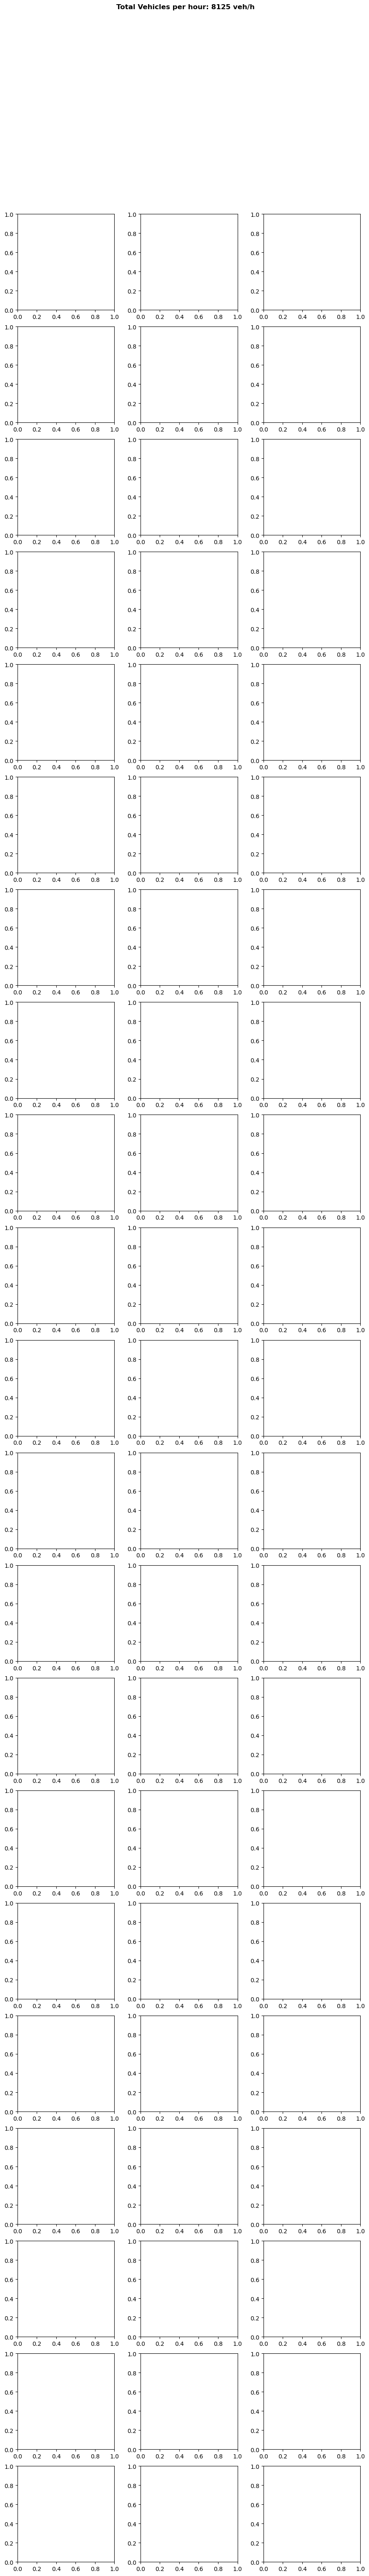

In [9]:
if __name__ == "__main__":
    
    # random vehicle routes
    random_routes = False
    
    # random vehicle parameters
    random_vehicle_parameters = False
    
    # sub directory of the roadnet file
    subdirect = "Manhattan"
    
    total_frequencies, total_bins = main(subdirect, random_routes, random_vehicle_parameters)

In [5]:
# Get the values from the dictionary
arrays = list(total_frequencies.values())

# Use zip to iterate over the corresponding elements
result = np.sum(list(zip(*arrays)), axis=1)

pair_sums = np.array([int(sum(result[i:i+2])) for i in range(0, len(result), 2)])

pair_sums

AxisError: axis 1 is out of bounds for array of dimension 1